### Oil type by origin "US" (general attribution)
Goal: Determine general case of fuel allocation 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yaml

In [2]:
# User inputs
file_dir  = '/Users/rmueller/Data/MIDOSS/DeptOfEcology/'
file_name = 'MuellerTrans4-30-20.xlsx'

master_dir  = '/Users/rmueller/Projects/MIDOSS/analysis-rachael/notebooks/monte_carlo/'
master_file = 'master.yaml'

with open(f'{master_dir}{master_file}') as file:
    master = yaml.safe_load(file)

vessel_types = master['categories']['tank_vessels']
fuel_types   = master['categories']['fuel_type']

In [3]:
vessel_types

['tanker', 'atb', 'barge']

In [4]:
# Import columns are: (G) Deliverer, (H) Receiver, (P) Product, 
#                     (Q) Quantity in Gallons, (R) Transfer Type (Fueling, Cargo, or Other)', 
#                     (w) DelivererTypeDescription, (x) ReceiverTypeDescription 
df = pd.read_excel(f'{file_dir}{file_name}',sheet_name='Vessel Oil Transfer', 
                   usecols="G,H,P,Q,R,W,X")

#### Extract cargo data transferred from vessel to facility

In [5]:
# list of names in DOE dataset that are used as "DelivererTypeDescription" for vessel transfers
vessel_names = ['TANK SHIP', 'TANK BARGE', 'TUGBOAT']
# Get all cargo fuel transfers
bool_cargo = df['TransferType']=='Cargo'
cargo_data = df[bool_cargo]
cargo_from_facility = cargo_data[ cargo_data['DelivererTypeDescription']=='Facility' ]
cargo_to_tank   = cargo_from_facility[ cargo_from_facility['ReceiverTypeDescription'] == 'TANK SHIP' ]
cargo_to_barge  = cargo_from_facility[ cargo_from_facility['ReceiverTypeDescription'] == 'TANK BARGE' ] 
cargo_to_tug    = cargo_from_facility[ cargo_from_facility['ReceiverTypeDescription'] == 'TUGBOAT' ]

# reset indices so they increase chronologically from 0 instead of keeping parent index values
cargo_to_tank.reset_index( drop=True, inplace=True )
cargo_to_barge.reset_index( drop=True, inplace=True )
cargo_to_tug.reset_index( drop=True, inplace=True )

In [6]:
[nrows,ncols] = cargo_to_barge.shape

In [7]:
# create ATB and tank barge dataframes
cargo_to_atb = pd.DataFrame(columns = cargo_to_barge.columns)
for row in range(nrows):
    if 'ITB' in cargo_to_barge.Receiver[row] or 'ATB' in cargo_to_barge.Receiver[row]:
        cargo_to_atb = cargo_to_atb.append( cargo_to_barge.iloc[row] )

for row in range(nrows):
    if 'ITB' in cargo_to_barge.Receiver[row] or 'ATB' in cargo_to_barge.Receiver[row]:        
        cargo_to_barge = cargo_to_barge.drop([row])


# reset indexing        
cargo_to_atb.reset_index( drop=True, inplace=True )

In [8]:
# concatenate tank barge dataframes
cargo_to_barge = pd.concat([cargo_to_barge, cargo_to_tug])

# reset indexing
cargo_to_barge.reset_index( drop=True, inplace=True )

### Total up the volume of fuel by fuel category for vessel types used in this study

In [9]:
# create dictionary structure
US = {}
for vessel in vessel_types:
    US[vessel]={}
    for fuel in fuel_types:
        US[vessel][fuel]={}
        US[vessel][fuel]['total_gallons']=0
        US[vessel][fuel]['number_of_transfers']=0
        US[vessel][fuel]['fraction_of_total']=0

#### Tankers

In [10]:
[nrows,ncols] = cargo_to_tank.shape
label = 'tanker'
for row in range(nrows):
    
    if 'CRUDE' in cargo_to_tank.Product[row]:
        US[label]['akns']['total_gallons'] += cargo_to_tank.TransferQtyInGallon[row].item()
        US[label]['akns']['number_of_transfers'] += 1

    elif cargo_to_tank.Product[row] == 'BUNKER OIL/HFO':
        US[label]['bunker']['total_gallons'] += cargo_to_tank.TransferQtyInGallon[row].item()
        US[label]['bunker']['number_of_transfers'] += 1

    elif cargo_to_tank.Product[row] == 'GASOLINE':
        US[label]['gas']['total_gallons'] += cargo_to_tank.TransferQtyInGallon[row].item()
        US[label]['gas']['number_of_transfers'] += 1

    elif cargo_to_tank.Product[row] == 'JET FUEL/KEROSENE':
        US[label]['jet']['total_gallons'] += cargo_to_tank.TransferQtyInGallon[row].item()
        US[label]['jet']['number_of_transfers'] += 1

    elif 'DIESEL' in cargo_to_tank.Product[row]: 
        # inclusive if BIODIESEL, DIESEL/MARINE GAS OIl, and DIESEL LOW SULPHUR (ULSD)
        US[label]['diesel']['total_gallons'] += cargo_to_tank.TransferQtyInGallon[row].item()
        US[label]['diesel']['number_of_transfers'] += 1

    else:
        US[label]['other']['total_gallons'] += cargo_to_tank.TransferQtyInGallon[row].item()
        US[label]['other']['number_of_transfers'] += 1    

In [11]:
US[label]['other']['total_gallons']

203598467

#### ATBs

In [12]:
[nrows,ncols] = cargo_to_atb.shape
label = 'atb'
for row in range(nrows):
    
    if 'CRUDE' in cargo_to_atb.Product[row]:
        ### WHY DOES ADDING A .ITEM() HERE GIVE AN ERROR WHEN IT DOESN'T ABOVE?
        US[label]['akns']['total_gallons'] += cargo_to_atb.TransferQtyInGallon[row]
        US[label]['akns']['number_of_transfers'] += 1

    elif cargo_to_atb.Product[row] == 'BUNKER OIL/HFO':
        US[label]['bunker']['total_gallons'] += cargo_to_atb.TransferQtyInGallon[row]
        US[label]['bunker']['number_of_transfers'] += 1

    elif cargo_to_atb.Product[row] == 'GASOLINE':
        US[label]['gas']['total_gallons'] += cargo_to_atb.TransferQtyInGallon[row]
        US[label]['gas']['number_of_transfers'] += 1

    elif cargo_to_atb.Product[row] == 'JET FUEL/KEROSENE':
        US[label]['jet']['total_gallons'] += cargo_to_atb.TransferQtyInGallon[row]
        US[label]['jet']['number_of_transfers'] += 1

    elif 'DIESEL' in cargo_to_atb.Product[row]: 
        # inclusive if BIODIESEL, DIESEL/MARINE GAS OIl, and DIESEL LOW SULPHUR (ULSD)
        US[label]['diesel']['total_gallons'] += cargo_to_atb.TransferQtyInGallon[row]
        US[label]['diesel']['number_of_transfers'] += 1

    else:
        US[label]['other']['total_gallons'] += cargo_to_atb.TransferQtyInGallon[row]
        US[label]['other']['number_of_transfers'] += 1   

#### Barges

In [13]:
[nrows,ncols] = cargo_to_barge.shape
label = 'barge'

for row in range(nrows):
    
    if 'CRUDE' in cargo_to_barge.Product[row]:
        US[label]['akns']['total_gallons'] += cargo_to_barge.TransferQtyInGallon[row].item()
        US[label]['akns']['number_of_transfers'] += 1

    elif cargo_to_barge.Product[row] == 'BUNKER OIL/HFO':
        US[label]['bunker']['total_gallons'] += cargo_to_barge.TransferQtyInGallon[row].item()
        US[label]['bunker']['number_of_transfers'] += 1

    elif cargo_to_barge.Product[row] == 'GASOLINE':
        US[label]['gas']['total_gallons'] += cargo_to_barge.TransferQtyInGallon[row].item()
        US[label]['gas']['number_of_transfers'] += 1

    elif cargo_to_barge.Product[row] == 'JET FUEL/KEROSENE':
        US[label]['jet']['total_gallons'] += cargo_to_barge.TransferQtyInGallon[row].item()
        US[label]['jet']['number_of_transfers'] += 1

    elif 'DIESEL' in cargo_to_barge.Product[row]: 
        # inclusive if BIODIESEL, DIESEL/MARINE GAS OIl, and DIESEL LOW SULPHUR (ULSD)
        US[label]['diesel']['total_gallons'] += cargo_to_barge.TransferQtyInGallon[row].item()
        US[label]['diesel']['number_of_transfers'] += 1

    else:
        US[label]['other']['total_gallons'] += cargo_to_barge.TransferQtyInGallon[row].item()
        US[label]['other']['number_of_transfers'] += 1   


#### Determine percent oil for each oil type

In [14]:
for vessel in vessel_types:

    # first get the total transfers over all fuel types
    total = sum([ US[vessel][fuel]['total_gallons'] for fuel in fuel_types ])

    for fuel in fuel_types:
  
        # next calculate percentages
        if total != 0:
            US[vessel][fuel]['fraction_of_total'] = round(
                US[vessel][fuel]['total_gallons'] / total, 
                4
            )

#  Check to make sure fraction of total sums to 1
for vessel in vessel_types:
    sum_check = [US[vessel][fuel]['fraction_of_total'] for fuel in fuel_types]
    if sum(sum_check) != 1 and sum(sum_check) != 0:
        # add oil to "other" category to fix sum to 1
        shortfall  = 1-sum(sum_check)
        US[vessel]['other']['fraction_of_total'] += shortfall
        print(f'{vessel} SHORTFALL:{shortfall} (corrected)')

        # double check
        sum_check = [US[vessel][fuel]['fraction_of_total'] for fuel in fuel_types]
        if sum(sum_check) != 1 and sum(sum_check) !=0 :
            print(f'NOT THERE YET!: {vessel}, {facility}:{sum(sum_check_out)}')

    elif sum(sum_check) != 1:
        print(f' {vessel}:{sum(sum_check_in)}')
 

tanker SHORTFALL:0.00010000000000010001 (corrected)
atb SHORTFALL:9.999999999998899e-05 (corrected)


In [15]:
with open(r'./US_origin.yaml', 'w') as file:
    documents = yaml.safe_dump(US, file)

#### Plot results

In [16]:
fuel_types

['akns', 'bunker', 'dilbit', 'jet', 'diesel', 'gas', 'other']

Text(0.5,1,'tanker fuel allocation for origin = US')

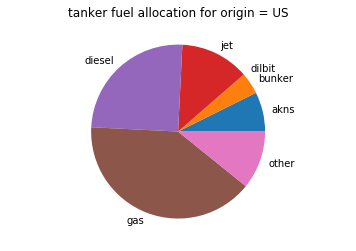

In [17]:
label = 'tanker'
US_tank = [ US[label]['akns']['total_gallons'], 
                US[label]['bunker']['total_gallons'], 
                US[label]['dilbit']['total_gallons'], 
                US[label]['jet']['total_gallons'], 
                US[label]['diesel']['total_gallons'], 
                US[label]['gas']['total_gallons'], 
                US[label]['other']['total_gallons']
               ]
plt.gca().axis("equal")
plt.pie(US_tank, labels= fuel_types)
plt.title(f'{label} fuel allocation for origin = US')

Text(0.5,1,'atb fuel allocation for origin = US')

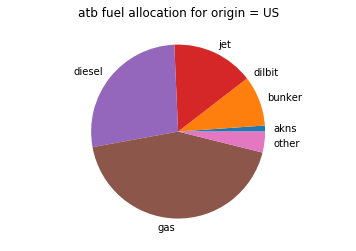

In [18]:
label = 'atb'
US_tank = [ US[label]['akns']['total_gallons'], 
                US[label]['bunker']['total_gallons'], 
                US[label]['dilbit']['total_gallons'], 
                US[label]['jet']['total_gallons'], 
                US[label]['diesel']['total_gallons'], 
                US[label]['gas']['total_gallons'], 
                US[label]['other']['total_gallons']
               ]
plt.gca().axis("equal")
plt.pie(US_tank, labels= fuel_types)
plt.title(f'{label} fuel allocation for origin = US')

Text(0.5,1,'barge fuel allocation for origin = US')

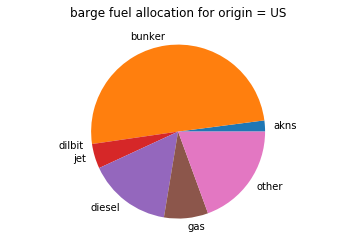

In [19]:
label = 'barge'
US_tank = [ US[label]['akns']['total_gallons'], 
                US[label]['bunker']['total_gallons'], 
                US[label]['dilbit']['total_gallons'], 
                US[label]['jet']['total_gallons'], 
                US[label]['diesel']['total_gallons'], 
                US[label]['gas']['total_gallons'], 
                US[label]['other']['total_gallons']
               ]
plt.gca().axis("equal")
plt.pie(US_tank, labels= fuel_types)
plt.title(f'{label} fuel allocation for origin = US')